# space-filling curve

## utils

In [41]:
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator

In [49]:
def plot(points, ax=None, figsize=(4, 4)):
    if ax is None:
        plt.figure(figsize=figsize)
        ax = plt.gca()
    x, y = zip(*points)
    ax.plot(x, y)
    ax.xaxis.set_major_locator(MaxNLocator(integer=True))
    ax.yaxis.set_major_locator(MaxNLocator(integer=True))
    ax.xaxis.tick_top()
    ax.invert_yaxis()
    plt.tight_layout()

def plot_orders(f, orders=[1, 2, 3, 4]):
    n = len(orders)
    fig, axs = plt.subplots(1, n, figsize=(4 * n, 4))
    for size, ax in zip(orders, axs.flatten()):
        points = f(size)
        plot(points, ax=ax)

## z-order curve

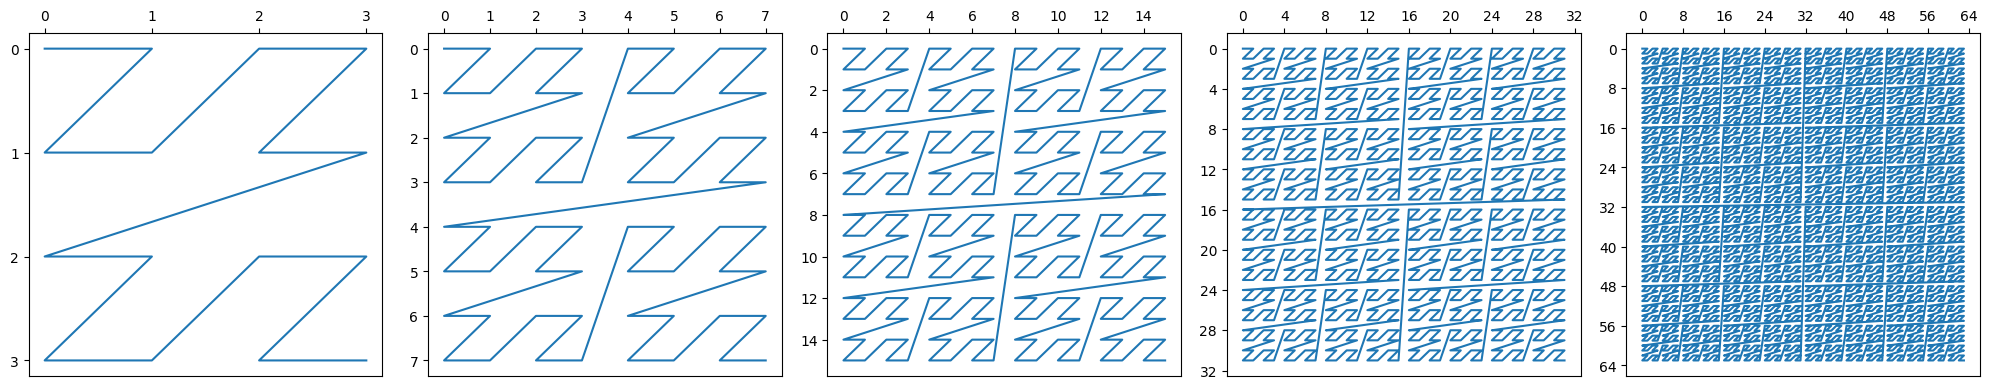

In [50]:
def z_order_curve(size):
    res = []
    for ii in range(size):
        for jj in range(size):
            i, j = ii, jj
            index, shift = 0, 0
            while i or j:
                pair = (i & 1) | ((j & 1) << 1)
                index |= pair << shift
                shift += 2
                i >>= 1
                j >>= 1
            res.append((index, ii, jj))
    res.sort()
    return [(i, j) for _, i, j in res]

plot_orders(z_order_curve, [4, 8, 16, 32, 64])